### Cluster the response of cells

In [76]:
import glob
from pathlib import Path
import xarray as xr
from sklearn import decomposition, manifold, preprocessing, cluster
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from scipy import signal, spatial

In [2]:
path = '/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22'

In [3]:
neuropixel_path = sorted(glob.glob(path+'/*/ephys/states.npy'))

In [5]:
# check output
for p in neuropixel_path:
    metrics_file = Path(p).parent.parent/'processed'/'cell_metrics_full.nc'
    if not metrics_file.exists():
        print(p)

### Load files

In [6]:
path = '/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22'
files = list(Path(path).glob('*/processed/xr_spikes_trials.nc'))

In [7]:
data_list = []
df_cell_prop = []
for i in tqdm(range(len(files))):
    dataset = xr.open_dataset(files[i])
    da = dataset['spikes_zFR.first_spout']
    da = da.mean(dim='trial_nb') #need to speed up the merge
    data_list.append(da)

    df = pd.read_pickle(files[i].parent/'df_cell_prop.pkl')
    df_cell_prop.append(df)
cell_da = xr.merge(data_list)
df_cell_prop = pd.concat(df_cell_prop)

  0%|          | 0/23 [00:00<?, ?it/s]

In [9]:
cell_da

<xarray.Dataset>
Dimensions:                 (cluID: 13267, spk_event_time: 251)
Coordinates:
  * cluID                   (cluID) object 'RE607-2023-07-13-121341_ProbeA_0'...
  * spk_event_time          (spk_event_time) float64 -500.0 -490.0 ... 2e+03
Data variables:
    spikes_zFR.first_spout  (spk_event_time, cluID) float64 -0.03477 ... -0.0302

In [10]:
df_cell_prop.columns

Index(['spikes_FR.trial_onset:pvalues', 'spikes_FR.trial_onset:pvalue_ratio',
       'spikes_FR.trial_onset:max_region_size',
       'spikes_FR.first_bar_off:pvalues',
       'spikes_FR.first_bar_off:pvalue_ratio',
       'spikes_FR.first_bar_off:max_region_size',
       'spikes_FR.last_bar_off:pvalues', 'spikes_FR.last_bar_off:pvalue_ratio',
       'spikes_FR.last_bar_off:max_region_size',
       'spikes_FR.first_spout:pvalues', 'spikes_FR.first_spout:pvalue_ratio',
       'spikes_FR.first_spout:max_region_size', 'spikes_FR.reward:pvalues',
       'spikes_FR.reward:pvalue_ratio', 'spikes_FR.reward:max_region_size',
       'spikes_FR.pre-cue1000:pvalues', 'spikes_FR.pre-cue1000:pvalue_ratio',
       'spikes_FR.pre-cue1000:max_region_size', 'cluID', 'pos_x', 'pos_y',
       'maxWaveformCh'],
      dtype='object')

In [11]:
# only include significant cells
max_region_size = df_cell_prop['spikes_FR.first_spout:max_region_size']
df_sel = df_cell_prop[(max_region_size>10) & (max_region_size<100)]
df_sel

,spikes_FR.trial_onset:pvalues,spikes_FR.trial_onset:pvalue_ratio,spikes_FR.trial_onset:max_region_size,spikes_FR.first_bar_off:pvalues,spikes_FR.first_bar_off:pvalue_ratio,spikes_FR.first_bar_off:max_region_size,spikes_FR.last_bar_off:pvalues,spikes_FR.last_bar_off:pvalue_ratio,spikes_FR.last_bar_off:max_region_size,spikes_FR.first_spout:pvalues,...,spikes_FR.reward:pvalues,spikes_FR.reward:pvalue_ratio,spikes_FR.reward:max_region_size,spikes_FR.pre-cue1000:pvalues,spikes_FR.pre-cue1000:pvalue_ratio,spikes_FR.pre-cue1000:max_region_size,cluID,pos_x,pos_y,maxWaveformCh
1,"[0.1782178217821782, 0.25742574257425743, 0.37...",0.075697,0.0,"[0.5742574257425742, 0.8316831683168316, 0.910...",0.290837,15.0,"[0.019801980198019802, 0.019801980198019802, 0...",0.685259,82.0,"[0.019801980198019802, 0.019801980198019802, 0...",...,"[0.8712871287128713, 0.6534653465346535, 0.316...",0.494024,33.0,"[0.3564356435643564, 0.2376237623762376, 0.138...",0.127490,0.0,kms058-2023-03-24-151254_ProbeA_101,48,480,49.0
2,"[0.9900990099009901, 0.8910891089108911, 0.653...",0.095618,0.0,"[0.6732673267326733, 0.9306930693069307, 0.990...",0.135458,11.0,"[0.019801980198019802, 0.019801980198019802, 0...",0.402390,33.0,"[0.019801980198019802, 0.019801980198019802, 0...",...,"[0.09900990099009901, 0.15841584158415842, 0.1...",0.219124,13.0,"[0.07920792079207921, 0.0594059405940594, 0.13...",0.079681,0.0,kms058-2023-03-24-151254_ProbeA_107,32,500,51.0
9,"[0.5742574257425742, 0.4158415841584158, 0.257...",0.386454,30.0,"[0.019801980198019802, 0.019801980198019802, 0...",0.649402,0.0,"[0.019801980198019802, 0.039603960396039604, 0...",0.470120,99.0,"[0.019801980198019802, 0.019801980198019802, 0...",...,"[0.019801980198019802, 0.019801980198019802, 0...",0.195219,29.0,"[0.0594059405940594, 0.0594059405940594, 0.039...",0.298805,16.0,kms058-2023-03-24-151254_ProbeA_115,48,560,57.0
11,"[0.0594059405940594, 0.0594059405940594, 0.079...",0.091633,0.0,"[0.49504950495049505, 0.3564356435643564, 0.21...",0.231076,15.0,"[0.31683168316831684, 0.31683168316831684, 0.3...",0.258964,60.0,"[0.49504950495049505, 0.7128712871287128, 0.97...",...,"[0.019801980198019802, 0.019801980198019802, 0...",0.127490,29.0,"[0.019801980198019802, 0.019801980198019802, 0...",0.151394,12.0,kms058-2023-03-24-151254_ProbeA_117,16,560,56.0
13,"[0.37623762376237624, 0.33663366336633666, 0.4...",0.334661,13.0,"[0.019801980198019802, 0.019801980198019802, 0...",0.350598,44.0,"[0.019801980198019802, 0.019801980198019802, 0...",0.876494,66.0,"[0.019801980198019802, 0.019801980198019802, 0...",...,"[0.019801980198019802, 0.019801980198019802, 0...",0.856574,84.0,"[0.15841584158415842, 0.09900990099009901, 0.0...",0.462151,28.0,kms058-2023-03-24-151254_ProbeA_12,32,100,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,"[0.5346534653465347, 0.31683168316831684, 0.17...",0.035857,0.0,"[0.25742574257425743, 0.297029702970297, 0.198...",0.231076,20.0,"[0.019801980198019802, 0.019801980198019802, 0...",0.896414,0.0,"[0.297029702970297, 0.039603960396039604, 0.03...",...,"[0.09900990099009901, 0.0594059405940594, 0.03...",0.071713,0.0,"[0.8118811881188119, 0.8514851485148515, 0.435...",0.051793,0.0,RE607-2023-07-18-124226_ProbeA_682,0,3220,322.0
301,"[0.019801980198019802, 0.039603960396039604, 0...",0.035857,0.0,"[0.2376237623762376, 0.0594059405940594, 0.019...",0.091633,10.0,"[0.019801980198019802, 0.019801980198019802, 0...",0.900398,49.0,"[0.019801980198019802, 0.019801980198019802, 0...",...,"[0.9900990099009901, 0.7128712871287128, 0.594...",0.031873,0.0,"[0.5148514851485149, 0.6534653465346535, 0.891...",0.039841,0.0,RE607-2023-07-18-124226_ProbeA_696,0,3300,330.0
304,"[0.1188118811881188, 0.1188118811881188, 0.118...",0.023904,0.0,"[0.019801980198019802, 0.019801980198019802, 0...",0.366534,16.0,"[0.9108910891089109, 0.7722772277227723, 1.0, ...",0.047809,0.0,"[0.15841584158415842, 0.4158415841584158, 0.83...",...,"[0.019801980198019802, 0.0396039603

In [12]:
da = cell_da['spikes_zFR.first_spout'].sel(cluID=df_sel.cluID.values)
da_mean  = da

### Clustering

In [13]:
# Normalize to -1 and 1 due to z scored data
data = da_mean.data.T
data_norm = preprocessing.maxabs_scale(data,axis=1) 

# smooth the curve


In [26]:
data_smooth = signal.savgol_filter(data_norm,21,1)

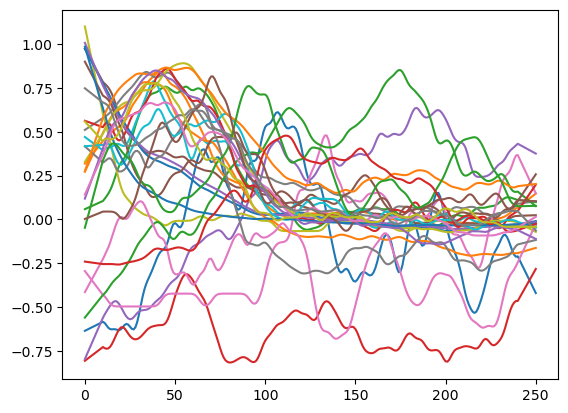

In [110]:
plt.plot(data_smooth.T[:,1:30]);

In [45]:
pca = decomposition.PCA(n_components=3)
pca.fit(data_smooth)
X = pca.transform(data_smooth)

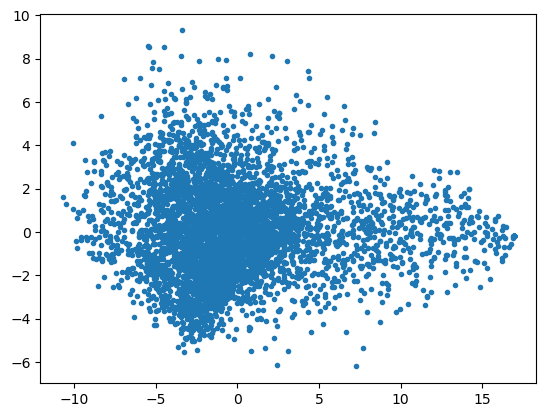

In [46]:
plt.plot(X[:,0], X[:,1],'.')

In [83]:
spatial.distance.correlation(data_smooth[0,:], data_smooth[1,:])

0.6807413809491136

In [109]:
# bandwidth = cluster.estimate_bandwidth(X, quantile=0.1, n_samples=500)
# print(bandwidth)
# see https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html#sklearn.metrics.pairwise_distances
clustering = cluster.DBSCAN(min_samples=10, eps=0.005, metric='mahalanobis').fit(X)
np.unique(clustering.labels_)

ValueError: Must provide either V or VI for Mahalanobis distance

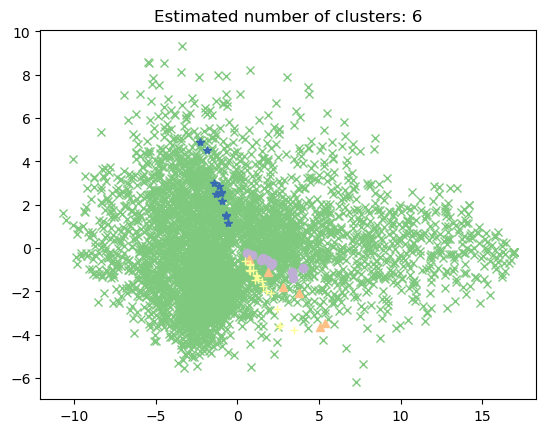

In [106]:
labels = clustering.labels_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

colors = plt.cm.Accent.colors
markers = ["x", "o", "^",'+','*']

for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    plt.plot(X[my_members, 0], X[my_members, 1], markers[k%len(markers)], color=col)
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

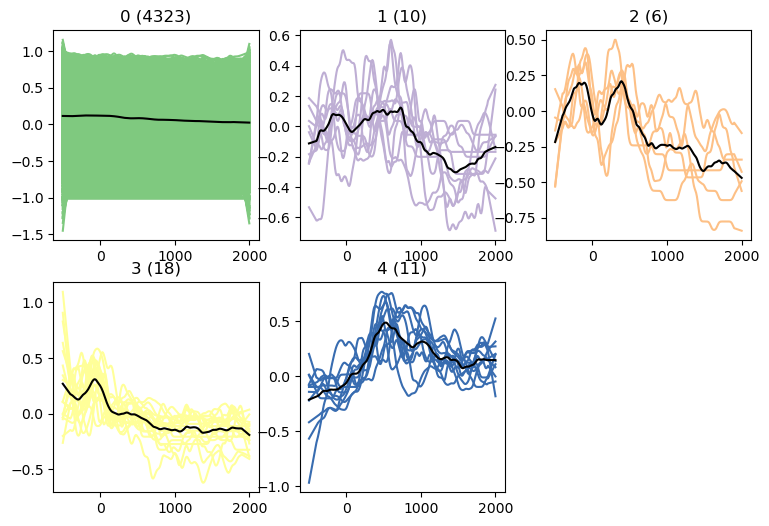

In [107]:
# plot average curve

ncol=3
nrow = (len(labels_unique)-1)//ncol+1
fig = plt.figure(figsize=(ncol*3,nrow*3))
colors = plt.cm.Accent.colors


for idx,lbl in enumerate(labels_unique[1:]):
    ax = fig.add_subplot(nrow, ncol, idx+1)
    ax.set_title(f'{lbl} ({np.sum(labels==lbl)})')
    curves = data_smooth[labels==lbl,:].T
    ax.plot(da.spk_event_time  , curves, color=colors[idx%len(colors)]);
    ax.plot(da.spk_event_time  , curves.mean(axis=1), color='k');